# Artificial Intelligence - 2nd Assignment

- Firstly, we import the necessary libraries, packages and methods.

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Machine Learning
from scipy import stats
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve,roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn import linear_model,preprocessing
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from prettytable import PrettyTable 

<hr>
<br>

## 1. Dataset Analysis and Review

dataFrame = pd.read_csv('../files/card_transdata.csv')
dataFrame.fillna(value=0,inplace=True)
dataFrame.head()

Attributes:
 
Attribute | Type | Properties | Discrete vs Continuous |
| - | - | - | - |
| Distance from home | Ratio |  Distinctness, Order, Meaningful differences and Meaningful ratios | Continuous |
| Distance from last transaction | Ratio | Distinctness, Order, Meaningful differences and Meaningful ratios | Continuous |
| Ratio of purchased price to median purchased price | Ratio |  Distinctness, Order, Meaningful differences and Meaningful ratios | Continuous |
| Repeat Retailer | Nominal (binary) | Distinctness | Discrete |
| Used chip (used credit card) | Nominal (binary) | Distinctness | Discrete | 
| Used pin (used pin number) | Nominal (binary) | Distinctness | Discrete |
| Online Order | Nominal (binary) | Distinctness | Discrete |


In [107]:
dataFrame = pd.read_csv('../files/card_transdata.csv')
dataFrame.fillna(value=0,inplace=True)
dataFrame.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


<hr>
<br>

- Now we are checking if there is any duplicated data.
- If yes, we remove duplicated objects.
- For this specific dataset, there isn't any duplicated data.

In [108]:
length = len(dataFrame)
dataFrame.drop_duplicates(keep = False)
cleanedDups = len(dataFrame)

print("Original dataset length: ", length)
print("Number of dups: ", length - cleanedDups)

Original dataset length:  1000000
Number of dups:  0


<hr>
<br>

- You can now find basic statistics about our problem.

In [109]:
dataFrame = dataFrame.sample(5000)
dataFrame.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000
mean,26.263061,5.249699,1.838163,0.88540,0.351600,0.11020,0.647600,0.092800
std,59.105958,27.390163,2.768132,0.31857,0.477518,0.31317,0.477766,0.290181
min,0.053519,0.000676,0.019576,0.00000,0.000000,0.00000,0.000000,0.000000
25%,3.751740,0.278062,0.456082,1.00000,0.000000,0.00000,0.000000,0.000000
50%,9.530197,0.985782,0.976432,1.00000,0.000000,0.00000,1.000000,0.000000
75%,24.959589,3.279281,2.118810,1.00000,1.000000,0.00000,1.000000,0.000000
max,1512.813857,1408.687641,41.928067,1.00000,1.000000,1.00000,1.000000,1.000000


<hr>
<br>

sdfgsdg

<hr>
<br>

- In this step, we use a sample of our dataset since the given one is too long, reaching 1000000 objects.
- After that, we create two new datasets: one only containing fraudlent transactions (fraud attribute = 1) and another contaning only non-fraudlent transactions (fraud attribute = 0)

In [110]:
#No fraud (class == 0) meaning legit transactions
#Fraud (class == 1) meaning fraudulent transactions

#Creating new data frames for No fraud and Fraud cases
no_fraud=dataFrame[dataFrame.fraud == 0]
fraud=dataFrame[dataFrame.fraud == 1]

#Resampling the original dataset with 10,000 datapoints
no_fraud_resample=no_fraud.sample(n=100)
fraud_resample=fraud.sample(n=100)

#Creating new dataset consisting of equal class occurence 
data=pd.concat([no_fraud_resample,fraud_resample],axis=0)

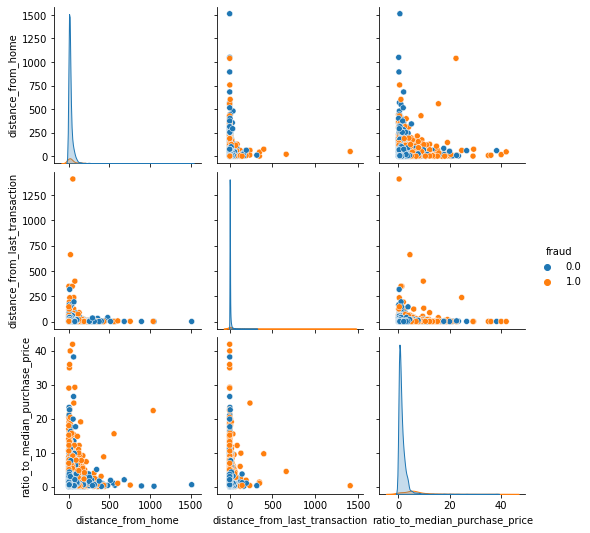

In [111]:
%matplotlib inline

sns.pairplot(dataFrame, vars =["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"], hue = 'fraud')

In [112]:
#dataFrame['distance_from_home'] = np.where((dataFrame['distance_from_home']<1900 & dataFrame['fraud'] == 0) |dataFrame['fraud'] == 1)
#dataFrame = fraud.loc[(dataFrame['fraud'] == 1) | (dataFrame['distance_from_last_transaction'] >= 10)]
#dataFrame = fraud.loc[(dataFrame['fraud'] == 0) | (dataFrame['ratio_to_median_purchase_price'] >= 10)]

#%matplotlib inline

#sns.pairplot(dataFrame, vars =["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"], hue = 'fraud')

TypeError: Cannot perform 'rand_' with a dtyped [float64] array and scalar of type [bool]

In [ ]:
#Splitting the dataset
train_features,test_features,train_labels,test_labels = train_test_split(features,target,stratify=target,shuffle=True,random_state=43)

NameError: name 'features' is not defined

In [ ]:
#Standardising the dataset
scale=MinMaxScaler().fit(train_features)
train_features_scaled=scale.transform(train_features)
test_features_scaled=scale.transform(test_features)

In [ ]:
#Creating empty list to store model evaluation values
data_all=[]

4. Model Training

In [ ]:
model_name = 'Random Forest'
model = RandomForestClassifier()
param_rf={
    "n_estimators": range(2,15,2),
    "max_features": range(1,7),
    "max_depth": range(1,10)
}

random_rf = RandomizedSearchCV(estimator = model, 
                                param_distributions = param_rf, 
                                n_iter = 15, 
                                cv = 10,
                                scoring = 'accuracy', 
                                verbose = 1, 
                                n_jobs = -1,
                                random_state = 1)

random_rf.fit(train_features, train_labels)
model = random_rf.best_estimator_
crossval = cross_val_score(model,
                            train_features,
                            train_labels,
                            cv = 5,
                            scoring = 'accuracy')

scores = np.mean(crossval)

test_pred = model.predict(test_features)
test_recall = recall_score(test_labels, 
                            test_pred, 
                            pos_label = 1)
fpr, tpr, thresholds = roc_curve(test_labels, 
                                test_pred, 
                                pos_label = 1)
test_auc = auc(fpr, tpr)

print('Train acc:', round(scores * 100, 2), '%')
print('Test acc:', round(accuracy_score(test_labels, test_pred) * 100, 2), '%')
print('Best n_estimators:', random_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_features:', random_rf.best_estimator_.get_params()['max_features'])
print('Best max_depth:', random_rf.best_estimator_.get_params()['max_depth'])

test_pred = model.predict(test_features)
cm = confusion_matrix(test_labels, test_pred)
clr = classification_report(test_labels, test_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, 
            annot = True, 
            vmin = 0, 
            fmt = 'g', 
            cbar = False, 
            cmap = 'Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix:Random Forest")
plt.show()
print(clr)

if accuracy_score(test_labels, test_pred) - scores < 1:
    result_model = 'Good Model'
    data_all.append([model,
                    scores,
                    accuracy_score(test_labels, test_pred),
                    test_recall, 
                    test_auc,
                    result_model])
else:
    result_model = 'Bad Model'
    data_all.append([model,
                    scores,
                    accuracy_score(test_labels, test_pred),
                    test_recall,
                    test_auc,
                    result_model])

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s

[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ..........................C=1, gamma=10, kernel=rbf; total time=   0.0s
[CV] END ..........................C=1, gamma=

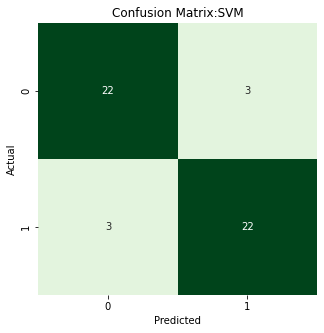

Classification Report:
----------------------
               precision    recall  f1-score   support

         0.0       0.88      0.88      0.88        25
         1.0       0.88      0.88      0.88        25

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



In [ ]:
data_all=[]
model_name='SVM'
model= SVC()
param_svm={
    "C":[100,10,1,0.1],
    "gamma": [10,1,0.1,0.001],
    "kernel": ['rbf']
    }

random_svm=RandomizedSearchCV(estimator=model, param_distributions=param_svm, n_iter = 15 , scoring='accuracy', cv = 10, verbose=2, n_jobs=-1,random_state=43)
random_svm.fit(train_features_scaled,train_labels)

model=random_svm.best_estimator_
crossval = cross_val_score(model,train_features_scaled,train_labels,cv=5,scoring='accuracy')
scores = np.mean(crossval)

test_pred=model.predict(test_features_scaled)
test_recall = recall_score(test_labels, test_pred, pos_label=1)
fpr, tpr, thresholds = roc_curve(test_labels, test_pred, pos_label=1)
test_auc = auc(fpr, tpr)

print('Train accuracy:',round(scores*100,2),'%')
print('Test accuracy:',round(accuracy_score(test_labels,test_pred)*100,2),'%')
print('Best C:',random_svm.best_estimator_.get_params()['C'])
print('Best gamma:',random_svm.best_estimator_.get_params()['gamma'])
print('Best kernel:',random_svm.best_estimator_.get_params()['kernel']) 

test_pred=model.predict(test_features_scaled)
cm = confusion_matrix(test_labels, test_pred)
clr = classification_report(test_labels, test_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: SVM")
plt.show()
print("Classification Report:\n\n", clr)

if accuracy_score(test_labels,test_pred)-scores <1:
    result_model='Good Model'
    data_all.append([model_name,scores,accuracy_score(test_labels,test_pred),test_recall,test_auc,result_model])
else:
    result_model='Failed'
    data_all.append([model_name,scores,accuracy_score(test_labels,test_pred),test_recall,test_auc,result_model])

Defining a Function for Train and Test split - split is done on 80% train and 20% test (can be altered in test_size value). Initially done including all features.

In [ ]:
# Decision Tree model
des_tree_model = DecisionTreeClassifier()
drawing= des_tree_model.fit(x_train, y_train)
y_test_pred = des_tree_model.predict(x_test)
y_train_pred = des_tree_model.predict(x_train)
Accuracy_Test=accuracy_score(y_test, y_test_pred) * 100
Accuracy_Test= str(Accuracy_Test) + " %"
Accuracy_Train=accuracy_score(y_train, y_train_pred) * 100
Accuracy_Train= str(Accuracy_Train) + " %"
Train_Data_Score=des_tree_model.score(x_train, y_train) * 100
Train_Data_Score= str(Train_Data_Score) + " %"


#Construction of confusion matrix
confmat_train = confusion_matrix(y_train_pred, y_train)
confmat_test =  confusion_matrix(y_test_pred, y_test)
print ("\nConfusion matrix of Train Data\n", confmat_train)
print ("\nConfusion matrix of Test Data\n", confmat_test)
total=sum(sum(confmat_test))


#Calculation of Specificity
#Specificity = TN/(TN+FP)
sp = confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) * 100
sp= str(sp) + " %"


#Calculation of sensitivity
#Sensitivity= TP/(TP+FN)
sensi = confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) * 100
sensi= str(sensi) + " %"



myTable = PrettyTable(["Peformance Paramters", "Value"]) 
#Insert rows
myTable.add_row(["Accuracy of Test Data",Accuracy_Test]) 
myTable.add_row(["Accuracy of Train Data", Accuracy_Train]) 
myTable.add_row(["Data score of Train Data",Train_Data_Score]) 
myTable.add_row(["Specificity of the confusion matrix",sp]) 
myTable.add_row(["Sensitivity of the confusion matrix",sensi])

#print Output
print(myTable)

NameError: name 'x_train' is not defined

In [ ]:
# Confusion matrix of the Decision Tree
import matplotlib.pyplot as plt
%matplotlib inline  

def plot_confusionmat(cm, lab, test_or_train):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    f = ax.matshow(cm, cmap=plt.cm.turbo)
    plt.title('Confusion Matrix of the ' + test_or_train +' Decision Tree \n')
    fig.colorbar(f)
    ax.set_xticklabels([''] + lab)
    ax.set_yticklabels([''] + lab)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    s = [['TP','FN'], ['FP', 'TN']]
    for k in range(2):
        for l in range(2):
            plt.text(l,k, str(cm[k][l]))
    plt.show()

In [ ]:
plot_confusionmat(confmat_train, ["0","1"], "Training")
plot_confusionmat(confmat_test, ["0","1"], "Testing")

In [ ]:
#Decision Tree Drawing :
plt.figure(figsize=[60,40])
tree.plot_tree(des_tree_model,fontsize=20, rounded=True,impurity=True, precision=2)
#tree.plot_tree(drawing,fontsize=20, rounded=True,impurity=True, precision=2)
plt.show()

1. Modeling

In [ ]:
y = dataFrame['fraud']
X = dataFrame.drop('fraud', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

2. Pre-processing

In [ ]:
# List of continuous features
conts = list(dataFrame.columns[:3])

# List of categorical (0/1) features
cats = list(dataFrame.columns[3:-1])

transformations = [('continuous', StandardScaler(), conts), ('categorical', OrdinalEncoder(), cats)]
pipeline = ColumnTransformer(transformations)

In [ ]:
train_transformed = pipeline.fit_transform(X_train)

3. Baseline Model

In [ ]:
baseline = LogisticRegression(max_iter=110)

In [ ]:
baseline.fit(train_transformed, y_train)

In [ ]:
test_transformed = pipeline.transform(X_test)

baseline_preds = baseline.predict(test_transformed)

In [ ]:
baseline.score(test_transformed, y_test)

In [ ]:
confusion_matrix(y_test, baseline_preds)

In [ ]:
precision_score(y_test, baseline_preds)

In [ ]:
recall_score(y_test, baseline_preds)

4. Complex Model

In [ ]:
svc_clf = SVC(kernel='rbf', gamma='auto')

In [ ]:
svc_clf.fit(train_transformed, y_train)

In [ ]:
svc_clf.score(test_transformed, y_test)

In [ ]:
svc_preds = svc_clf.predict(test_transformed)

In [ ]:
confusion_matrix(y_test, svc_preds)

In [ ]:
precision_score(y_test, svc_preds)

In [ ]:
recall_score(y_test, svc_preds)